In [1]:
# add path
import sys
sys.path.append('../Deliverable_2/')
sys.path.append('../Deliverable_3/')

import pandas as pd 
import numpy as np
import itertools

# import utils functions and classes
from DataLoader import TADataLoader
from TextPreprocessing import TextPreprocessor, split_reviews_per_sentence
from ReviewPreprocessing import review_preprocessing

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)

# import tensorflow functions
import tensorflow as tf

from TrainingDataGenerator import generate_training_data
from EmbeddorSkipgram import Skipgram
from HierarchicalAttentionModel import HierarchicalAttentionNetwork
from plot_utils import PlotAttentionWeights

In [3]:
import tqdm
#tqdm.tqdm_notebook()
tqdm.notebook.tqdm().pandas()

# Load scrapped data

In [4]:
loader = TADataLoader(data_file='scrapped_data_balanced.jl')
df_reviews = loader.load_reviews(drop_duplicates=True)

In [5]:
df_reviews = df_reviews.sample(frac=0.02).reset_index(drop=True)

In [6]:
preprocessor = TextPreprocessor(df_reviews, column_to_clean='review_content')
preprocessor.transform(n_grams=False)
corpus = preprocessor.corpus

In [7]:
print('The initial size of the corpus is %.f.' % len(corpus))

The initial size of the corpus is 1384.


# Data augmentation

In [8]:
# to fill 

# Classification

In [9]:
df_reviews = split_reviews_per_sentence(df_reviews)

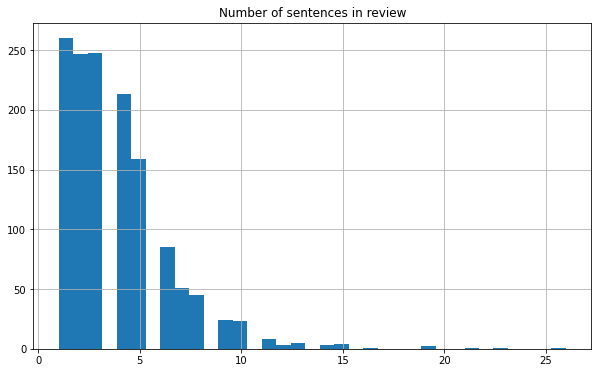

In [10]:
# Visualize number of sentences per review
df_reviews["review_sentences"].apply(len).hist(bins=35)
plt.title('Number of sentences in review')
plt.show()

### Get pretrained embedding weights

In [11]:
sentences = list(itertools.chain(*df_reviews["review_sentences"]))
print(f"Number of total sentences : {len(sentences)}")

tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=' ', char_level=False)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences) 

print(f"Number of total words : {max(tokenizer.index_word.keys())}")

Number of total sentences : 5233
Number of total words : 8970


In [12]:
targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=2, 
    num_ns=4, 
    vocab_size=max(tokenizer.index_word.keys())+1 
)

BATCH_SIZE = 1024
BUFFER_SIZE = 10000

dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset shapes: (((1024,), (1024, 5, 1)), (1024, 5)), types: ((tf.int32, tf.int64), tf.int64)>


In [13]:
embedding_dim = 128

word2vec = Skipgram(vocab_size=max(tokenizer.index_word.keys())+1, embedding_dim=128)
word2vec.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [14]:
word2vec.fit(dataset, epochs=20)

Epoch 1/20
39/39 [==============================] - 1s 36ms/step - loss: 1.6091 - accuracy: 0.2145
Epoch 2/20
39/39 [==============================] - 1s 30ms/step - loss: 1.5943 - accuracy: 0.6555
Epoch 3/20
39/39 [==============================] - 1s 27ms/step - loss: 1.5711 - accuracy: 0.8176
Epoch 4/20
39/39 [==============================] - 1s 27ms/step - loss: 1.5282 - accuracy: 0.8475
Epoch 5/20
39/39 [==============================] - 1s 25ms/step - loss: 1.4584 - accuracy: 0.8485
Epoch 6/20
39/39 [==============================] - 1s 25ms/step - loss: 1.3636 - accuracy: 0.8474
Epoch 7/20
39/39 [==============================] - 1s 28ms/step - loss: 1.2537 - accuracy: 0.8503
Epoch 8/20
39/39 [==============================] - 1s 23ms/step - loss: 1.1390 - accuracy: 0.8552
Epoch 9/20
39/39 [==============================] - 1s 23ms/step - loss: 1.0275 - accuracy: 0.8632
Epoch 10/20
39/39 [==============================] - 1s 23ms/step - loss: 0.9230 - accuracy: 0.8722
Epoch 11/

In [15]:
pretrained_weights = word2vec.get_layer('w2v_embedding').get_weights()[0]

### Predict review ratings 

In [16]:
df_reviews['usable_rating'] = df_reviews['review_rating'].apply(lambda r: int(r)-1)
rating_labels = tf.keras.utils.to_categorical(df_reviews['usable_rating'], num_classes=5, dtype='float32')

In [17]:
padded_preprocessed_reviews = [review_preprocessing(review, tokenizer) for review in tqdm.notebook.tqdm(df_reviews["review_sentences"])]
padded_preprocessed_reviews = tf.stack(padded_preprocessed_reviews)
padded_preprocessed_reviews.shape

TensorShape([1384, 10, 50])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(padded_preprocessed_reviews.numpy(), rating_labels, test_size=0.3)

# build tensorflow formatted datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

### Model selection

We summarize below the results obtained on a validation set for all hyperparameter combinations that have been tested.

In [19]:
# Base GRU + tanh: val_accuracy: 0.5782
# Downsample 5s + LSTM + ReLu: val_accuracy: 0.5617
# Downsample 5s + GRU + ReLu + dropout 20%: val_accuracy: 0.5578
# Downsample 5s + LSTM + tanh + dropout 20%: val_accuracy: 0.5656
# Downsample 5s + LSTM + tanh: val_accuracy: 0.5654

# Macro F1 score
# Downsample 5s + LSTM + tanh: val_f1_score: 0.5077
# Downsample 5s + GRU + tanh: val_f1_score: 0.4802
# Downsample 5s + LSTM + tanh + dropout 20% after Attention layer: val_f1_score: 0.5084
# Downsample 5s + LSTM + tanh + dropout 20% before Attention layer: val_f1_score: 0.4972
# Downsample 5s + LSTM + relu + dropout 20% after Attention layer: val_f1_score: 0.5041
# Downsample 5s + LSTM + selu + dropout 20% after Attention layer: val_f1_score: 0.4690
# Downsample 5s + LSTM + relu + dropout 20% in LSTM layers: val_f1_score: 0.5360
# Downsample 5s + LSTM + tanh + dropout 20% in LSTM layers: val_f1_score: 0.5340
# Downsample 5s + LSTM + relu + regularize(activity, bias, kernel l1=l2=0.02) + dropout 20% in LSTM layers: val_f1_score: 0.5247
# Downsample 5s + LSTM + relu + regularize(Dense kernel l2=0.001) + dropout 20% in LSTM layers: val_f1_score: 0.5210
# Downsample 5s + LSTM + relu + regularize(LSTM kernel l2=0.001) + dropout 20% in LSTM layers: val_f1_score: 0.5063
# Downsample 5s + LSTM + relu + regularize(LSTM kernel l2=0.001) + dropout 20% in LSTM layers + lr=0.005: val_f1_score: 0.4537
# Downsample 5s + LSTM + relu + regularize(Dense kernel l2=0.01) + dropout 20% in LSTM layers + lr=0.002: val_f1_score: 0.5281
# Downsample 5s + LSTM + relu + dropout 20% in LSTM layers + lr=0.002: val_f1_score: 0.5295
# Downsample 5s + LSTM + relu + dropout 30% in LSTM layers + lr=0.001: val_f1_score: 0.5376
# Downsample 5s + LSTM + relu + dropout 40% in LSTM layers + lr=0.001: val_f1_score: 0.5168
# Downsample 5s + LSTM + relu + dropout 40% in LSTM layers + lr=0.003: val_f1_score: 0.5196
# Downsample 5s + LSTM + relu + dropout 30% in LSTM layers + lr=0.001 + code correction: val_f1_score: 0.4904
# Downsample 5s + LSTM + relu + dropout 30% in LSTM layers + lr=0.005 + code correction: val_f1_score: 0.5429 
# Downsample 5s + LSTM + relu + dropout 30% in LSTM layers + lr=0.003 + code correction: val_f1_score: 0.5299
# Downsample 5s + LSTM + relu + dropout 30% in LSTM layers + lr=0.004 + code correction: val_f1_score: 0.5350
# Downsample 5s + LSTM + relu + regularize(Dense kernel l2=0.01) + dropout 30% in LSTM layers + lr=0.005 + code correction: val_f1_score: 0.5297

# Final model
# Downsample 5s + LSTM + relu + dropout 30% in LSTM layers + lr=0.005 + code correction: val_f1_score: 0.5470, val_accuracy: 0.5994

In [20]:
# initialize HAN model
han_model = HierarchicalAttentionNetwork(
    vocab_size=max(tokenizer.index_word.keys())+1, 
    embedding_dim=128, 
    pretrained_weights=pretrained_weights, 
    gru_units=32, 
    attention_units=32, 
    classifier_units=5
)

# load saved weights
han_model.load_weights('my_han_model/weights.index')

# compile (not needed here)
# han_model_loaded.compile(
#    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#    optimizer="adam",
#    metrics=["accuracy"])

#han_history = han_model.fit(
#    train_ds, 
#    epochs=5, 
#    validation_data=test_ds
#)

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


### Evaluate models

# Bonus: Attention words and sentences

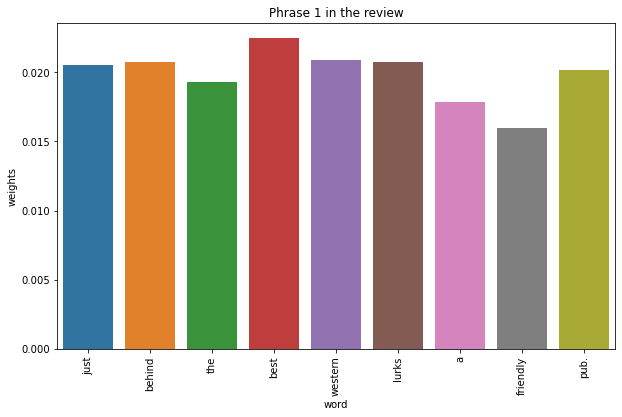

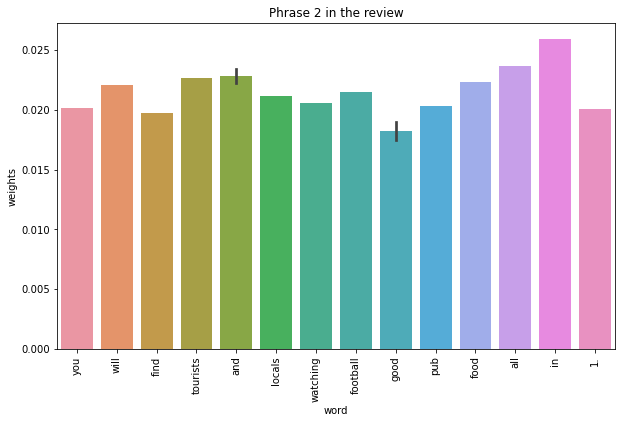

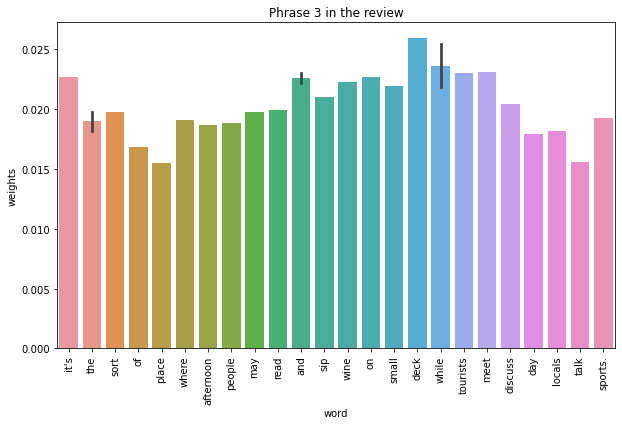

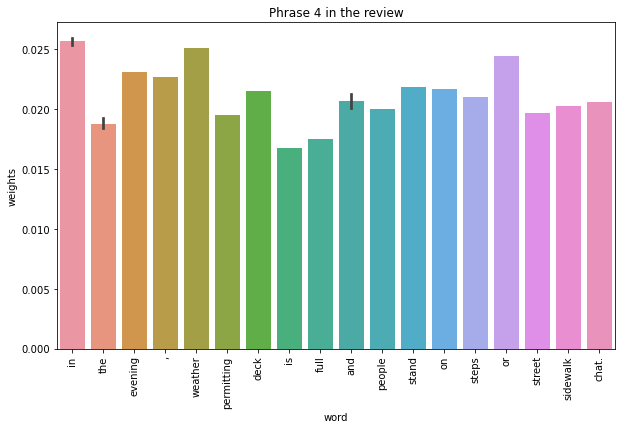

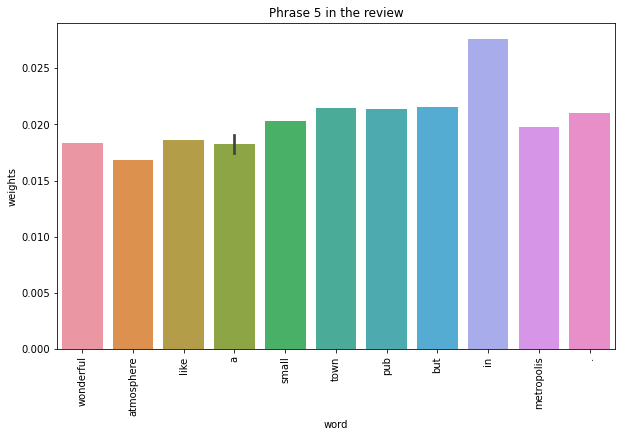

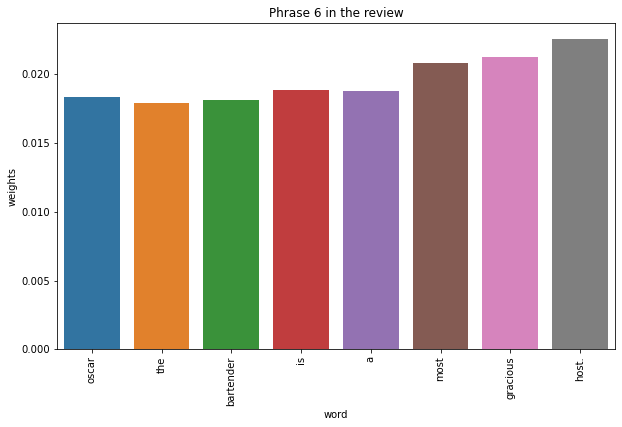

In [24]:
i = 15
example = padded_preprocessed_reviews[i:i+1]
reverse_word_mapper = dict(map(reversed, tokenizer.word_index.items()))

plotter = PlotAttentionWeights(padded_preprocessed_reviews[i:i+1], han_model, reverse_word_mapper)
plotter.plot_attention_weights_sentences()